In [1]:
from hestonpy.models.heston import Heston


# Parameters for the Heston model
S0 = 100.0  # Initial spot price
V0 = 0.06  # Initial volatility
r = 0.03  # Risk-free interest rate
kappa = 1.0  # Mean reversion rate
theta = 0.06  # Long-term volatility
drift_emm = 0.01  # Drift term
sigma = 0.3  # Volatility of volatility
rho = -0.5  # Correlation between asset and volatility
T = 1.0  # Time to maturity in years
K = 100.0  # Strike price

heston = Heston(S0, V0, r, kappa, theta, drift_emm, sigma, rho, T, K)

n=1000
S, V, _ = heston.simulate(scheme='euler', N=1, n=n)
dt = T / n

In [2]:
from arch import arch_model

import matplotlib.pyplot as plt
import numpy as np

In [3]:
model = arch_model(y=S, rescale=True, p=1, o=0, q=1, mean="AR", dist="gaussian").fit()
model

Iteration:      1,   Func. Count:      6,   Neg. LLF: 154619852252.46094
Iteration:      2,   Func. Count:     13,   Neg. LLF: 14805.733118113183
Iteration:      3,   Func. Count:     19,   Neg. LLF: 626263743.2246771
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4848.6339569463635
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3004.257307962156
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3140.697574389192
Iteration:      7,   Func. Count:     43,   Neg. LLF: 3123.0869587701354
Iteration:      8,   Func. Count:     49,   Neg. LLF: 3196.3983083259914
Iteration:      9,   Func. Count:     55,   Neg. LLF: 3138.891410833171
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2898.439715212886
Iteration:     11,   Func. Count:     66,   Neg. LLF: 3411.5196710429072
Iteration:     12,   Func. Count:     72,   Neg. LLF: 3208.8254598903463
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3117.7197354205455
Iteration:     14,   Func. Count:     84,   Neg. LLF: 30

                           AR - GARCH Model Results                           
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2884.19
Distribution:                  Normal   AIC:                           5776.38
Method:            Maximum Likelihood   BIC:                           5796.02
                                        No. Observations:                 1001
Date:                Mon, Feb 17 2025   Df Residuals:                     1000
Time:                        20:33:12   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const        106.2385      0.273    389.782      0.000 [1.

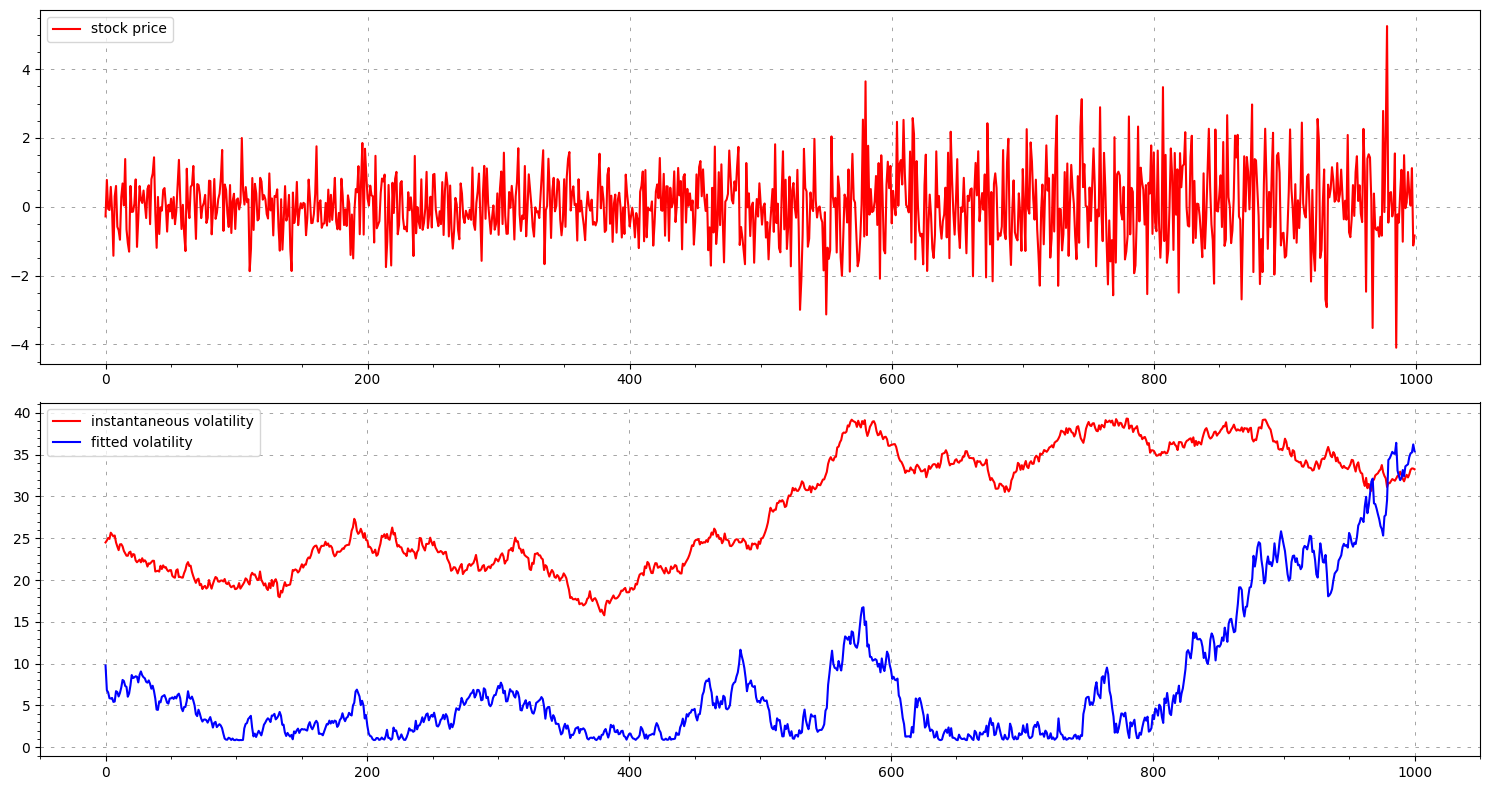

In [4]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,8))

ax1.plot(np.diff(S), label="stock price", color='red')
ax1.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
ax1.minorticks_on()
ax1.legend()

ax2.plot(np.sqrt(V)*100, label="instantaneous volatility", color='red')
ax2.plot(model.conditional_volatility, label="fitted volatility", color='blue')
ax2.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
ax2.minorticks_on()
ax2.legend()

plt.tight_layout()
plt.show()

In [30]:
import particles 
from particles import distributions as dists  # where probability distributions are defined
from particles import state_space_models as ssm  # where state-space models are defined
from particles.collectors import Moments

class HestonSSM(ssm.StateSpaceModel):
    def __init__(self, kappa:float, theta:float, sigma:float, rho:float, dt:float):
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.dt = dt

    def PX0(self):
        """Distribution initiale de la volatilité V_0"""
        return dists.Dirac(loc=V0)

    def PX(self, xp:float):
        """Dynamique de la volatilité V_t sous forme de distribution."""
        mean = xp * np.exp(- self.kappa * self.dt) + self.theta * (1 - np.exp(- self.kappa * self.dt))

        variance1 = self.sigma**2 * self.theta /(2 * self.kappa) 
        variance2 = self.sigma**2 * (xp - self.theta) / self.kappa * np.exp(- self.kapp * self.dt) 
        variance3 = self.sigma**2 * (self.theta - 2 * xp) / (2 * self.kappa) * np.exp(- 2 * self.kappa * dt)
        std = np.sqrt(variance1+variance2+variance3)

        return dists.Normal(loc=mean, scale=std)

    def PY(self, xp:float, y:float):
        """Loi de vraisemblance de l'observation log(S_t)."""
        return dists.Normal(loc=y, scale=np.sqrt(xp) * self.rho)

data = np.diff(np.log(S))

# Instanciation du modèle et du filtre particulaire
heston_ssm = HestonSSM(kappa, theta, sigma, rho, dt)
# fk_model = ssm.Bootstrap(ssm=heston_ssm, data=data)
# # Exécution du filtre particulaire
# pf = particles.SMC(
#     fk=fk_model, 
#     N=100, 
#     resampling='stratified',
#     collect=[Moments()], store_history=True
# )
# pf.run()
from particles import mcmc
prior_dict = {
    'theta': dists.Dirac(loc=theta),
    'rho': dists.Dirac(loc=V0),
    'sigma': dists.Dirac(loc=V0),
    'kappa': dists.Dirac(loc=kappa),
    'dt': dists.Dirac(loc=dt)
}
my_prior = dists.StructDist(prior_dict)

my_pmmh = mcmc.PMMH(
    ssm_cls=heston_ssm, 
    prior=my_prior, 
    data=data, 
    Nx=200,
    niter=1000
)
my_pmmh.run()

filtered_volatility = np.exp(np.array([m['mean'] for m in pf.summaries.moments]))
filtered_volatility

TypeError: 'HestonSSM' object is not callable

In [ ]:
class StochVol(ssm.StateSpaceModel):
    
    def PX0(self):  # Distribution of X_0
        return dists.Normal(loc=self.mu, scale=self.sigma / np.sqrt(1. - self.rho**2))
    
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        return dists.Normal(loc=self.mu + self.rho * (xp - self.mu), scale=self.sigma)
    
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        return dists.Normal(loc=0., scale=np.exp(0.5 * x))

my_model = StochVol(mu=-1., rho=.9, sigma=.1)  # actual model
fk_model = ssm.Bootstrap(ssm=my_model, data=data)  # we use the Bootstrap filter
pf = particles.SMC(fk=fk_model, N=100, resampling='stratified',
                   collect=[Moments()], store_history=True)  # the algorithm
pf.run()  # actual computation

filtered_volatility = np.exp(np.array([m['mean'] for m in pf.summaries.moments]))

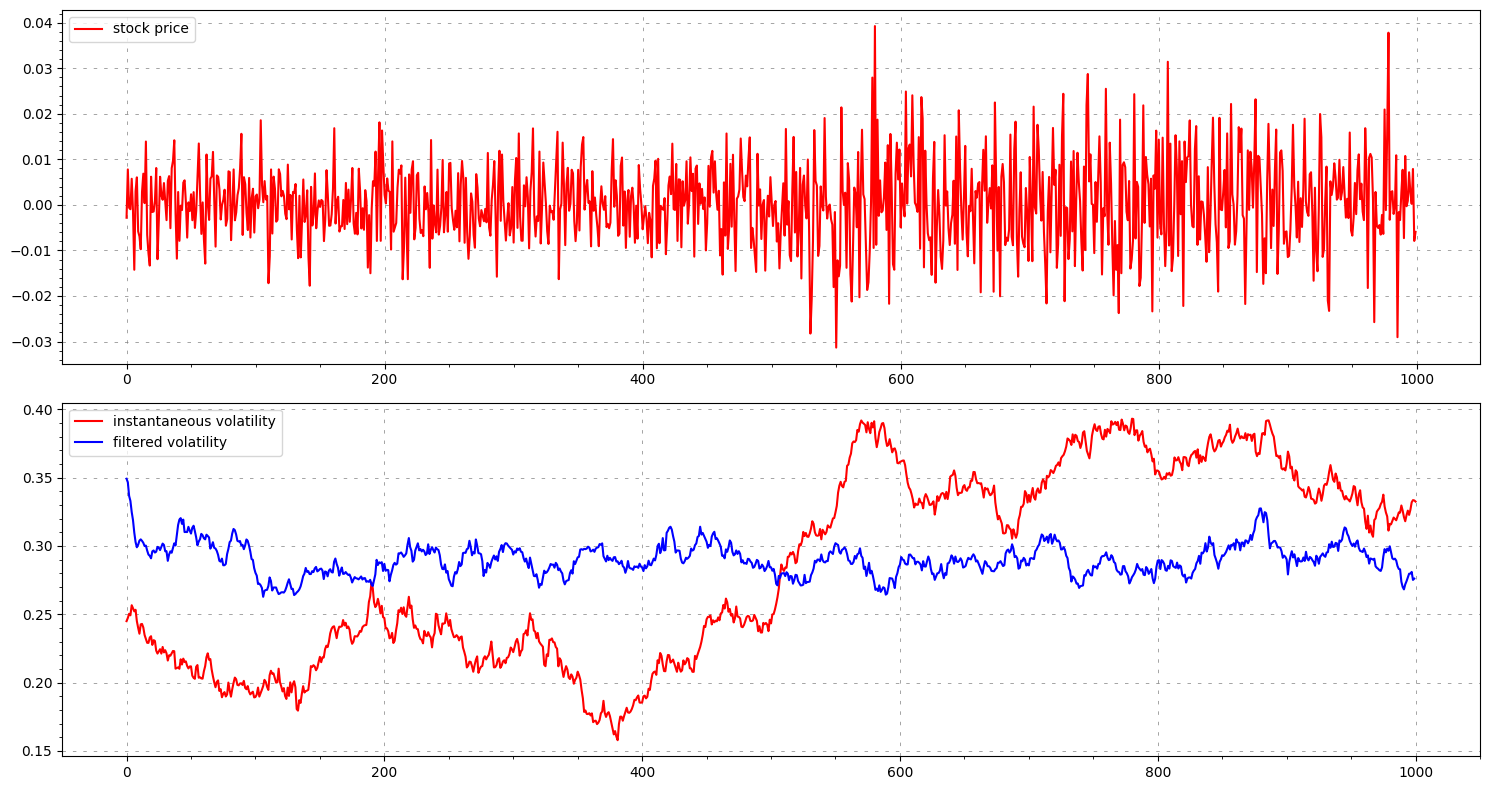

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,8))

ax1.plot(np.diff(np.log(S)), label="stock price", color='red')
ax1.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
ax1.minorticks_on()
ax1.legend()

ax2.plot(np.sqrt(V), label="instantaneous volatility", color='red')
ax2.plot(filtered_volatility, label='filtered volatility', color='blue')
ax2.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
ax2.minorticks_on()
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
prior_dict = {
    'mu':dists.Normal(),
    'sigma': dists.Gamma(a=1., b=1.),
    'rho':dists.Beta(9., 1.)
}
my_prior = dists.StructDist(prior_dict)
from particles import mcmc 
pmmh = mcmc.PMMH(ssm_cls=StochVol, prior=my_prior, data=data, Nx=50, niter = 1000)
pmmh.run()

KeyboardInterrupt: 

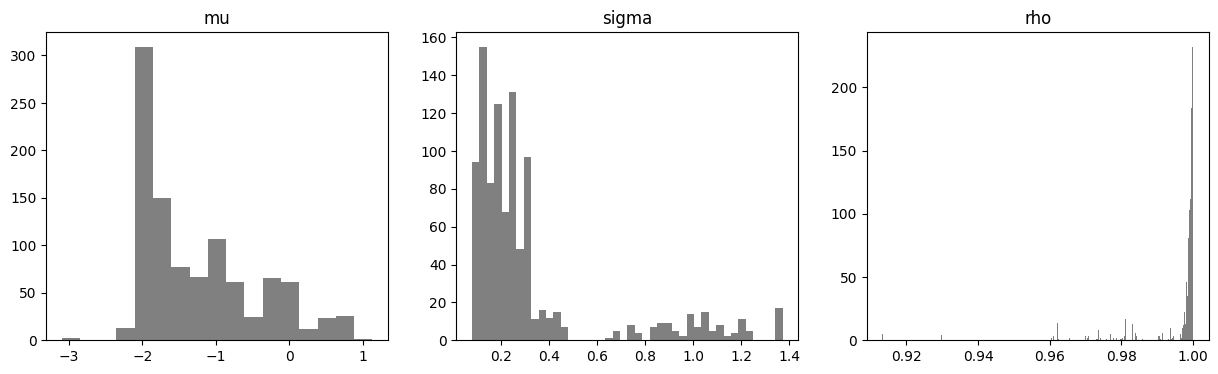

In [ ]:
# plot the marginals
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, param in enumerate(prior_dict.keys()):
    axes[i].hist(pmmh.chain.theta[param], bins='fd', color='gray')
    axes[i].set_title(param)